# Prédition de la consommation en électricité

In [1]:
# Importation des librairies nécessaires au projet
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import *

import warnings

In [2]:
#Fonction affichant le Test de Dickey–Fuller avec les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
    Test de Dickey–Fuller
    avec Autocorrélogrammes ACF et PACF

    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        
#Fonction affichant les 5 premières meilleurs combinaisaons de paramètres SARIMA
# En fonction de l'AIC et du BIC
def sarimax_gridsearch(ts, pdq, pdqs):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(ts,order=comb, seasonal_order=combs)
                output = mod.fit() 
                ans.append([comb, combs, output.bic, output.aic])
                #print('SARIMAX {} x {}12 : BIC Calculated ={} ; AIC Calculated : {}'.format(comb, combs, output.bic, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic', 'aic'],ascending=True)
    
    return ans_df.head()

## 1) Description de la consommation en énergie

In [3]:
# Chargement du dataset sur la consommation énergétique 
df = pd.read_csv('conso_energie.csv', encoding='latin-1')
df.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


On dispose de plusieurs informations sur la consommation en énergie du territoire français. On a des informations concernant la production totale ainsi que le découpage de ces productions (nucléaire, charbon, fioul, gaz, hydraulique, bioénergies), la consommation totale, le solde exportateur ainsi que les échanges avec des pays voisins avec le Royaume-Uni, l'Espagne, l'Italie, la Suisse, l'Allemagne et la Belgique.

### 1.1) Représentation et statistiques descriptives de la consommation électrique

Pour la suite de cette analyse, on va s'intéresse à la consommation électrique totale du territoire national uniquement. On va créer une variable contenant le logarithme de la consommation électrique pour pouvoir compléter notre analyse de la série temporelle de la consommation.

In [4]:
# Création d'un dataset avec la consommation et la date d'enregistrement de cette consommation
# Ajout d'une colonne contenant les logarithmes de chaque consommation

warnings.filterwarnings('ignore')

df_france = df.loc[(df['Territoire'] == 'France')]
df_france['log_consommation'] = df_france['Consommation totale'].apply(lambda x : np.log(x))

Une fois les données de consommation totale pour le territoire français extraits et rassemblés dans un unique tableau, on peut représenter graphiquement cette série temporelle. 

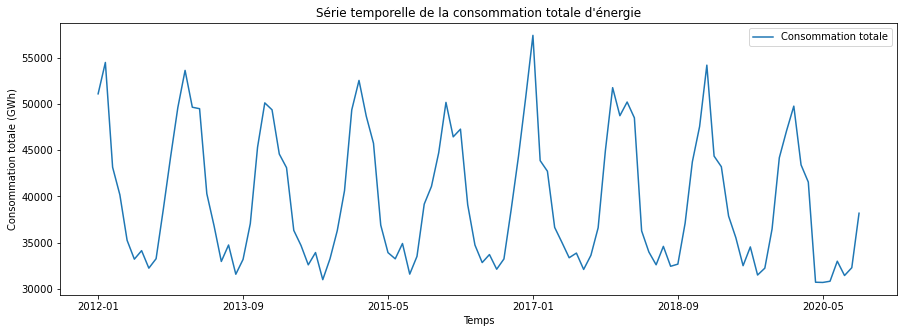

In [5]:
# Représentation graphique de la série temporelle

df_france.plot(x='Mois', y='Consommation totale', figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.title('Série temporelle de la consommation totale d\'énergie')
plt.show()

Une fois la série temporelle de la consommation totale d'énergie représentée graphiquement, on peut calculer différents indices pour décrire notre série. 

In [6]:
# Indice de tendance centrale

print('Moyenne de la série : ', round(df_france['Consommation totale'].mean(), 2))
print('Médiane de la série : ', round(df_france['Consommation totale'].median(), 2))

Moyenne de la série :  39668.58
Médiane de la série :  36980.5


In [7]:
# Indice de dispersion

print('Variance de la série : ', round(df_france['Consommation totale'].var(), 2))
print('Ecart-type de la série : ', round(df_france['Consommation totale'].std(), 2))
print('Etendue de la série : ', round(df_france['Consommation totale'].max() - df_france['Consommation totale'].min(), 2))

Variance de la série :  50656863.25
Ecart-type de la série :  7117.36
Etendue de la série :  26702


On représente ensuite la série temporelle à l'aide de la variable log_consommation. 

[]

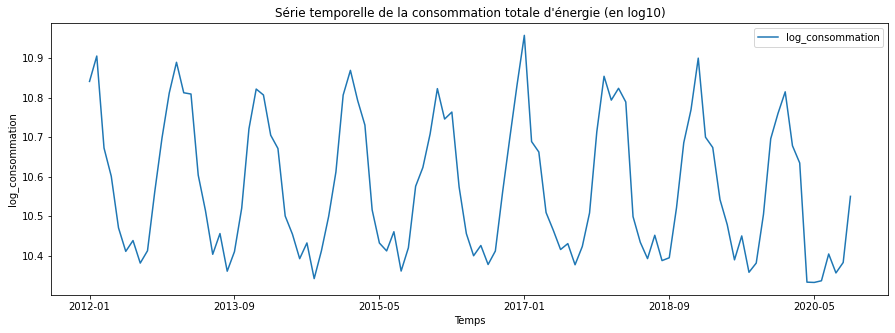

In [8]:
# Représentation de la consommation d'électricité en logarithme
df_france.plot(x='Mois', y='log_consommation',figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('log_consommation')
plt.title('Série temporelle de la consommation totale d\'énergie (en log10)')
plt.plot()

On remarque que la consommation brute ou transformée par une fonction logarithme ont la même forme. 

## 2) Description des données de température

On s'intéresse ensuite aux données concernant les variations de température que l'on nomme DJU. Les données téléchargées contiennent les informations de plusieurs villes, on calcule donc la moyenne nationale qui sera utilisée par la suite.

In [9]:
# Chargement du dataset contenant les températures exprimés en Degré Jour Unifié (DJU)

df_dju = pd.read_csv('DJU.csv',  sep=',', encoding='latin-1')
df_dju['DJU_mean'] = (df_dju['DJU_H1a']+df_dju['DJU_H1b']+df_dju['DJU_H1c']+df_dju['DJU_H2a']+df_dju['DJU_H2b']+df_dju['DJU_H2c']+df_dju['DJU_H2d']+df_dju['DJU_H3'])/8
df_dju.head()

,Mois,Territoire_H1a,DJU_H1a,Territoire_H1b,DJU_H1b,Territoire_H1c,DJU_H1c,Territoire_H2d,DJU_H2d,Territoire_H3,DJU_H3,Territoire_H2c,DJU_H2c,Territoire_H2b,DJU_H2b,Territoire_H2a,DJU_H2a,DJU_mean
0,2012-01,St-Quentin,398.1,Charleville-Mézières,430.9,Ambérieu,444.6,St Aubin,366.3,Nice,248.3,Bordeaux,333.6,Cognac,343.8,Brest,303.5,358.6375
1,2012-02,St-Quentin,497.8,Charleville-Mézières,531.8,Ambérieu,574.1,St Aubin,436.4,Nice,304.4,Bordeaux,439.2,Cognac,468.9,Brest,350.5,450.3875
2,2012-03,St-Quentin,276.8,Charleville-Mézières,313.3,Ambérieu,253.4,St Aubin,209.7,Nice,152.8,Bordeaux,201.0,Cognac,206.4,Brest,241.0,231.8000
3,2012-04,St-Quentin,291.4,Charleville-Mézières,294.1,Ambérieu,211.2,St Aubin,204.2,Nice,107.8,Bordeaux,210.4,Cognac,217.9,Brest,276.1,226.6375
4,2012-05,St-Quentin,152.9,Charleville-Mézières,128.4,Ambérieu,90.3,St Aubin,77.3,Nice,48.3,Bordeaux,58.4,Cognac,71.5,Brest,151.8,97.3625


### 2.1) Représentation graphique des DJU

On cherche à représenter graphiquement la série des températures entre 2012 et 2020.

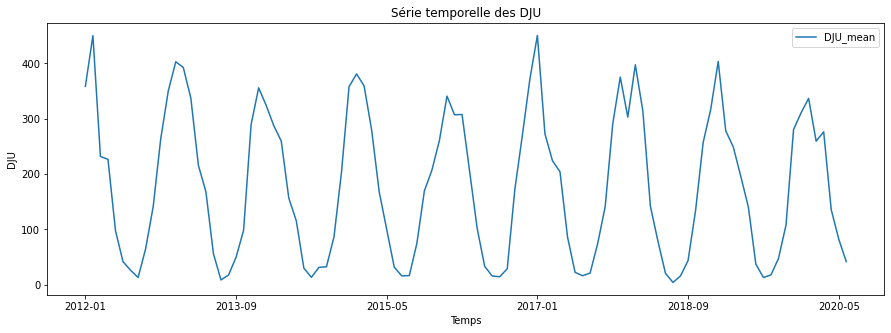

In [10]:
# Représentation graphiquement des températures en degré jour unifié

df_dju.plot(x='Mois',y='DJU_mean', figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('DJU')
plt.title('Série temporelle des DJU')
plt.show()

In [11]:
# Indice de tendance centrale
print('Moyenne de la série : ', round(df_dju['DJU_mean'].mean(), 2))
print('Médiane de la série : ', round(df_dju['DJU_mean'].median(), 2))

Moyenne de la série :  178.48
Médiane de la série :  167.94


In [12]:
# Indice de dispersion
print('Variance de la série : ', round(df_dju['DJU_mean'].var(), 2))
print('Ecart-type de la série : ', round(df_dju['DJU_mean'].std(), 2))
print('Etendue de la série : ', round(df_dju['DJU_mean'].max() - df_dju['DJU_mean'].min(), 2))

Variance de la série :  17666.31
Ecart-type de la série :  132.91
Etendue de la série :  446.89


La silhouette de la série temporelle des DJU suit celle de la consommation d'énergie électrique.

## 3) Analyses bivariées

Avant de corriger la consommation d'énergie à l'aide de la température en degré jour unifié, on crée un dataframe contenant uniquement les informations que l'on va utiliser pour la suite de notre étude. 

In [13]:
df = pd.merge(df_france, df_dju, on ='Mois')
df = df[['Mois', 'Consommation totale', 'DJU_mean']].set_index('Mois')
df.index = pd.to_datetime(df.index)
df.head()

,Consommation totale,DJU_mean
Mois,,
2012-01-01,51086,358.6375
2012-02-01,54476,450.3875
2012-03-01,43156,231.8000
2012-04-01,40176,226.6375
2012-05-01,35257,97.3625


In [14]:
del df_dju
del df_france

On regarde la distribution de nos deux variables.

### 3.1) Distribution de la consommation totale d'électricité

On représente graphiquement la distribution de la consommation d'électricité et on vérifie que cette distribution suit une loi normale. Pour cela, on va effectuer un test de Shapiro-Wilk avec les hypothèses : 
- H0 : Il est peu probable que la distribution de la consommation d'électricité suive une loi normale
- H1 : Il est probable que la distribution de la consommation d'électricité suive une loi normale.

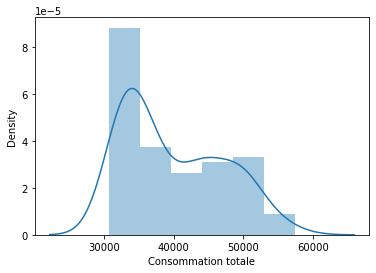

ShapiroResult(statistic=0.908640444278717, pvalue=3.0329144919960527e-06)

In [15]:
sns.distplot(df['Consommation totale'])
plt.show()
st.shapiro(df['Consommation totale'])

On obtient une p-value > 0.05, on peut donc rejeter l'hypothèse nulle H0 selon laquelle il es peu probable que notre distribution suive une loi normale. 

### 3.2) Distribution des températures en DJU

La démarche pour la distribution des températures selon le DJU moyen est la même que pour la consommation d'électricité. On va faire une représentation graphique de notre distribution puis on va effectuer un test de Shapiro-Wilk pour vérifier si notre distribution suit une loi normale. On va donc avoir les deux hypothèses suivantes : 
- H0 : Il est peu probable que la distribution des températures suive une loi normale
- H1 : Il est probable que la distribution des températures suive une loi normale

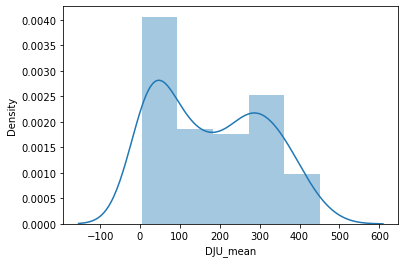

ShapiroResult(statistic=0.917353093624115, pvalue=8.482184966851491e-06)

In [16]:
sns.distplot(df['DJU_mean'])
plt.show()
st.shapiro(df['DJU_mean'])

Notre test indique une p-value < 0.05. On peut donc rejeter l'hypothèse H0 selon laquelle il est peu probable que notre distribution suive une loi normale.

La distribution des températures et de la consommation d'électricité suivent une loi normale.

### 3.3) Corrélation entre consommation et température

Une fois que l'on a montré que nos deux variables suivent une loi normale. On va pouvoir effectuer une corrélation entre ces deux variables. Ainsi, on obtiendra un modèle de régression linéaire qui nous permettra de corriger la consommation d'électricité en fonction de la température enregistrée. 

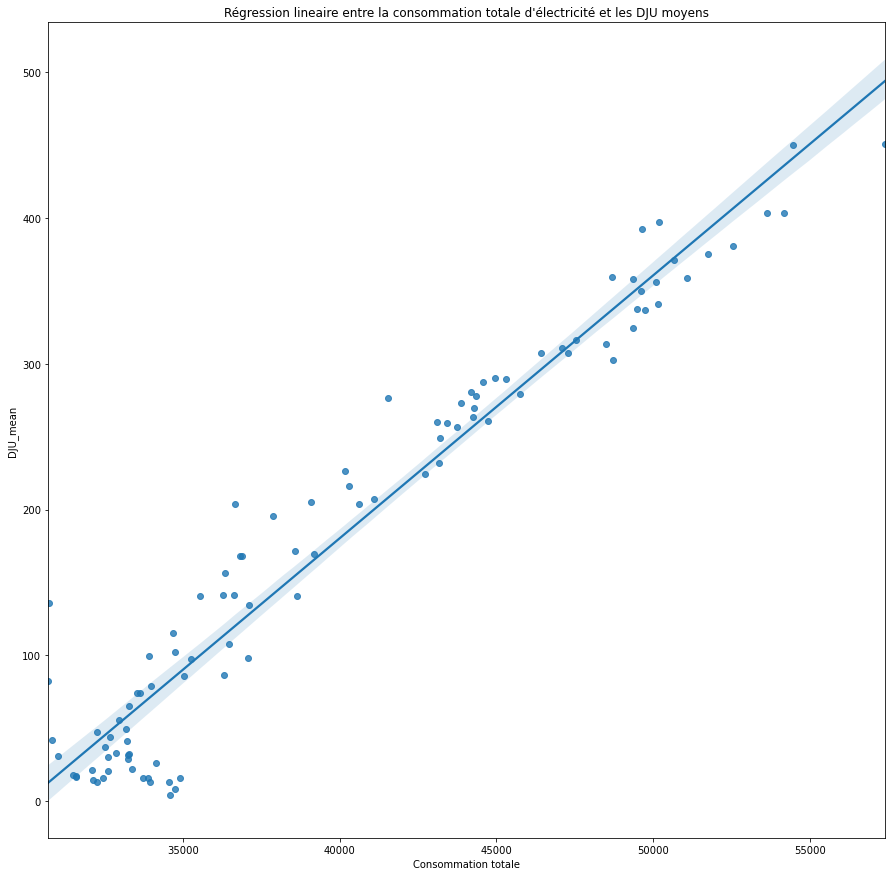

In [17]:
plt.figure(figsize=(15,15))
sns.regplot('Consommation totale', 'DJU_mean', data=df)
plt.title('Régression lineaire entre la consommation totale d\'électricité et les DJU moyens')
plt.show()

In [18]:
X = np.array(df['Consommation totale'])
y = np.array(df['DJU_mean'])

slope, intercept, r_value, p_value, std_err = st.linregress(X,y)
print('r-squared : ', r_value**2)
print('p-value : ', p_value)
print('slope :' , slope)

r-squared :  0.9378066929077119
p-value :  3.996670068899686e-62
slope : 0.018034418615795977


Notre régression linéaire montre un coefficient de détermination de 0.93. On en conclut qu'il y a une forte corrélation entre la consommation totale et la température en DJU. De plus, l'observation de notre graphique montre que cette corrélation est positive (plus la consommation augmente plus la différence de température est élevé). De plus, la p-value est inférieure à 0.05 donc notre corrélation est statistiquement significative.

On effectue une nouvelle régression linéaire pour créer une variable qui contient le paramètre de la régression associée à la température. Cette variable sera ensuite utilisée pour corriger la consommation d'énergie. 

In [19]:
x= sm.add_constant(df['DJU_mean'])
y = df['Consommation totale']

reg = sm.OLS(y, x).fit()
params = reg.params['DJU_mean']

### 3.4) Correction des données de consommation en électricité

On crée une nouvelle colonne dans notre dataframe qui contient les valeurs de la consommation totale corrigée grâce au paramètre de la régression linéaire que l'on a extrait plus tôt.

In [20]:
df['Consommation totale corrigée'] = df['Consommation totale'] - (df['DJU_mean'] * params)
df['Consommation totale corrigée'] = df['Consommation totale corrigée'].apply(lambda x : int(x))
df.head()

,Consommation totale,DJU_mean,Consommation totale corrigée
Mois,,,
2012-01-01,51086,358.6375,32436
2012-02-01,54476,450.3875,31055
2012-03-01,43156,231.8000,31102
2012-04-01,40176,226.6375,28390
2012-05-01,35257,97.3625,30194


Une fois la correction de la consommation calculée, on la représente graphiquement pour voir la différence entre consommation totale et consommation totale corrigée de la température.

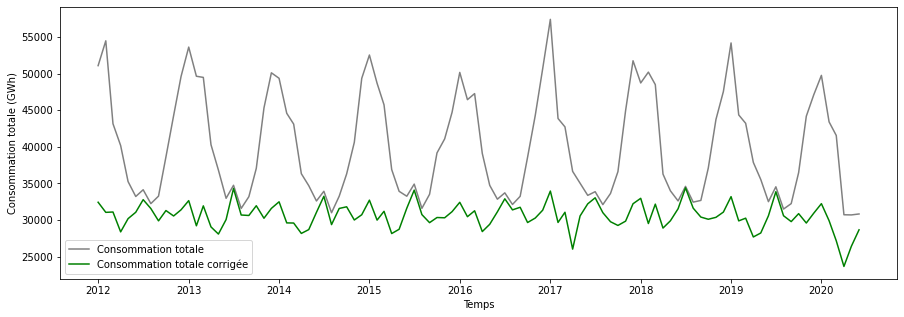

In [21]:
plt.figure(figsize=(15,5))
plt.plot(df['Consommation totale'], label='Consommation totale', color='grey')
plt.plot(df['Consommation totale corrigée'], label='Consommation totale corrigée', color='green')
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.legend(loc='best')
plt.show()

En ayant corrigé notre série temporelle sur la consommation d'électricité, on s'assure que les prédictions faites dans la suite de notre étude ne prenne en compte que les variations de consommation électrique sans être influencés par les variations de température extérieures. 

## 4) Décomposition de notre série temporelle

Une fois la correction effectuée, on peut s'intéresser aux différents composants de la série temporelle. 

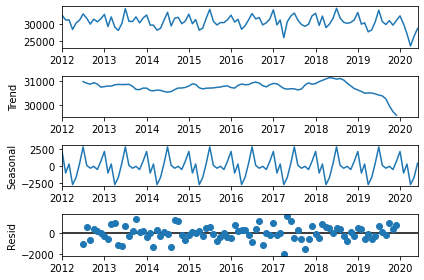

In [22]:
df_decomp = df[['Consommation totale corrigée']]
decomp_x = seasonal_decompose(df_decomp,  model='add')
decomp_x.plot()
plt.show()

On peut ainsi décomposer notre série temporelle en saisonnalité, en tendance et obtenir les résidus. On remarque que la tendance globale est plutôt avec une baisse entre 2019 et 2020. La saisonnalité apparaît de manière assez récurrent dans nos données et représente le même pattern. Pour mieux comprendre ce phénomène, on va créer une colonne qui va contenir la consommation désaisonnalisée à chaque mois. 

In [23]:
df['Saisonnalité'] = decomp_x.seasonal
df['Consommation désaisonnalisée'] = df['Consommation totale corrigée'] - df['Saisonnalité']

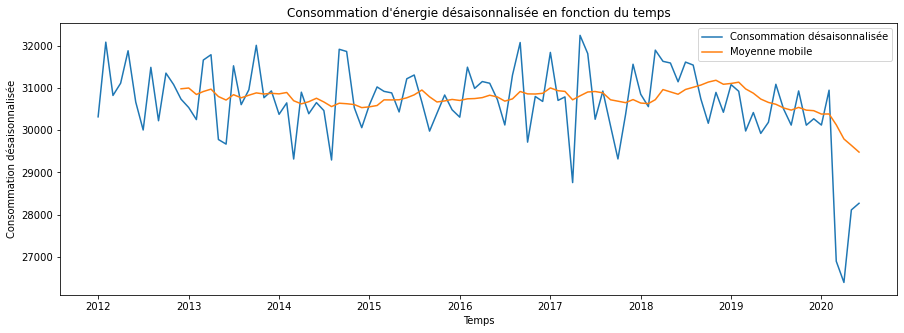

In [24]:
window_size = 12

windows = df['Consommation désaisonnalisée'].rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

plt.figure(figsize=(15,5))
plt.plot(df['Consommation désaisonnalisée'], label='Consommation désaisonnalisée')
plt.plot(moving_averages, label='Moyenne mobile')
plt.xlabel('Temps')
plt.ylabel('Consommation désaisonnalisée')
plt.title('Consommation d\'énergie désaisonnalisée en fonction du temps')
plt.legend(loc='best')
plt.show()

On remarque que la moyenne mobile de la consommation désaisonnalisée suit la tendance issue de la décomposition de notre série temporelle. Une fois cela effectuée, on va pouvoir tester plusieurs manières de modéliser et donc de prédire la consommation en énergie sur les douze prochains mois. 

## Modélisations et prédictions

### 1) A l'aide de la méthode de Holt-Winters

La méthode de Holt-Winters génère des valeurs lissées de façon exponentielle pour le niveau, la tendance et l'ajustement saisonnier de la série temporelle. Cette méthode convient pour les séries temporelles dont la saisonnalité et la tendance restent stables dans le temps.

Source : **https://docs.oracle.com/cloud/help/fr/pbcs_common/CSPPU/holt-winters_additive.htm**

##### a) Définition du modèle

On commence par définir les paramètres de notre modèle puis on le représente graphiquement. Ici les paramètres de notre modèle contiennent des informations sur la saisonnalité qui est égale à 12 et une tendance et une saisonnalité additives.

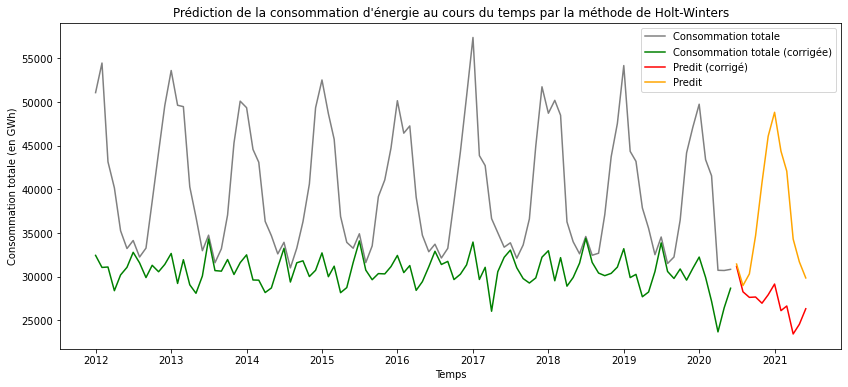

In [25]:
warnings.filterwarnings('ignore')
hw = ExponentialSmoothing(np.asarray(df['Consommation totale corrigée']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw2 = ExponentialSmoothing(np.asarray(df['Consommation totale']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)
hw_pred2 = hw2.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(df['Consommation totale'], label='Consommation totale', color='grey')
plt.plot(df['Consommation totale corrigée'], label='Consommation totale (corrigée)', color='green')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'),hw_pred, label='Predit (corrigé)', color='red')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'),hw_pred2, label='Predit', color='orange')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

Pour mieux comprendre les résultats obtenus avec notre modèle, on effectue une représentation graphique avec uniquement les données de consommation corrigée.

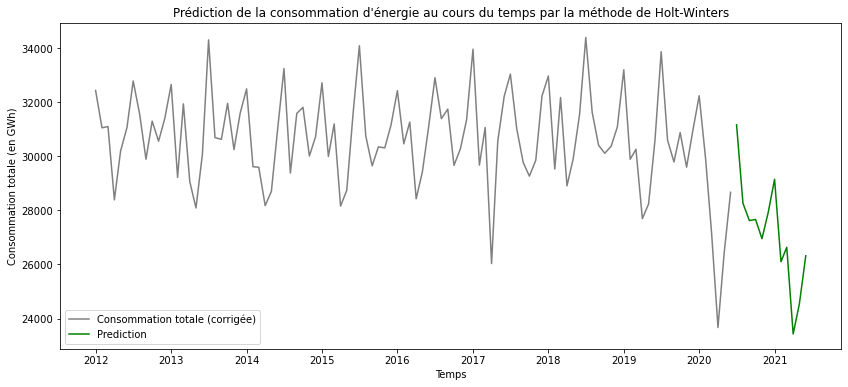

In [26]:
plt.figure(figsize=(14,6))
plt.plot(df['Consommation totale corrigée'], label='Consommation totale (corrigée)', color='gray')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'),hw_pred, label='Prediction', color='green')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

##### b) Evaluation du modèle

Une fois les paramètres de notre modèle définis, on évalue notre modèle. Pour cela, on enlève les données des 12 derniers mois dont on dispose puis on compare les valeurs enregistrées avec les valeurs prédites de nottre modèle.

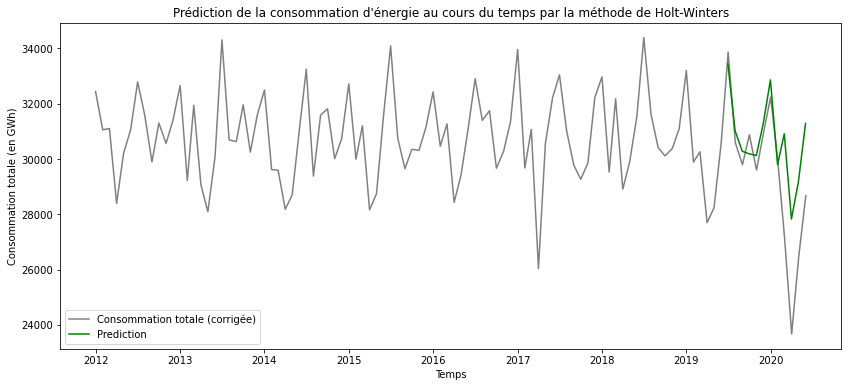

In [27]:
df_2 = df.drop(df.index[-12:])
warnings.filterwarnings('ignore')

hw = ExponentialSmoothing(np.asarray(df_2['Consommation totale corrigée']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(df['Consommation totale corrigée'], label='Consommation totale (corrigée)', color='gray')
plt.plot(pd.date_range(df_2.index[len(df_2)-1], periods=12, freq='M'), hw_pred, label='Prediction', color='green')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

Graphiquement, on remarque que la prédiction a réussi à capturer la saisonnalité mais qu'il a du mal à prédire la baisse importante du début de l'année 2020. Comme vu dans la définition de la méthode de Holt-Winters, ce modèle est bon pour prédire des événements lorsque la saisonnalité et la tendance sont stables. Or, selon la décomposition de notre série temporelle on remarque que la tendance est stable jusque 2019 mais qu'ensuite, elle s'effondre au début de l'année 2020.

Pour pouvoir conclure à l'évaluation de notre modèle, on va ensuite calculer différents indices.

In [28]:
y_pred = hw_pred
y_true = np.asarray(df_2['Consommation totale corrigée'].iloc[-12:])

In [29]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  421.70206974651165
MSE =  277744.4160897022
RMSE =  527.0146260681028
MAPE =  1.3645057748095852


Notre modèle obtient des scores plutôt bons avec une marge d'erreur (MAPE) de 1.36%. Cependant ce type de modélisation n'est pas adapté pour notre série temporelle où la tendance est à la baisse au début de l'année 2020.

#### A l'aide d'un modèle SARIMA

Pour contrer le problème de la difficulté de traitement de la présence d'une tendance et/ou d'une saisonnalité changeante, on va pouvoir utiliser un modèle issu de la méthode SARIMA. Cette méthode combine une méthode auto-regressive à une méthode de moyenne mobile. Cependant, on va devoir vérifier la non-stationnarité de notre série temporelle avant de pouvoir la réaliser. On commence donc par créer une variable qui ne contient que notre série temporelle de la consommation corrigée.

In [30]:
y = df['Consommation totale corrigée']

##### a) Analyses préalables

Après avoir crée une variable ne contenant que notre série temporelle, on va ensuite s'intéresser à la saisonnalité et au calcul de la stationnarité de notre série temporelle.

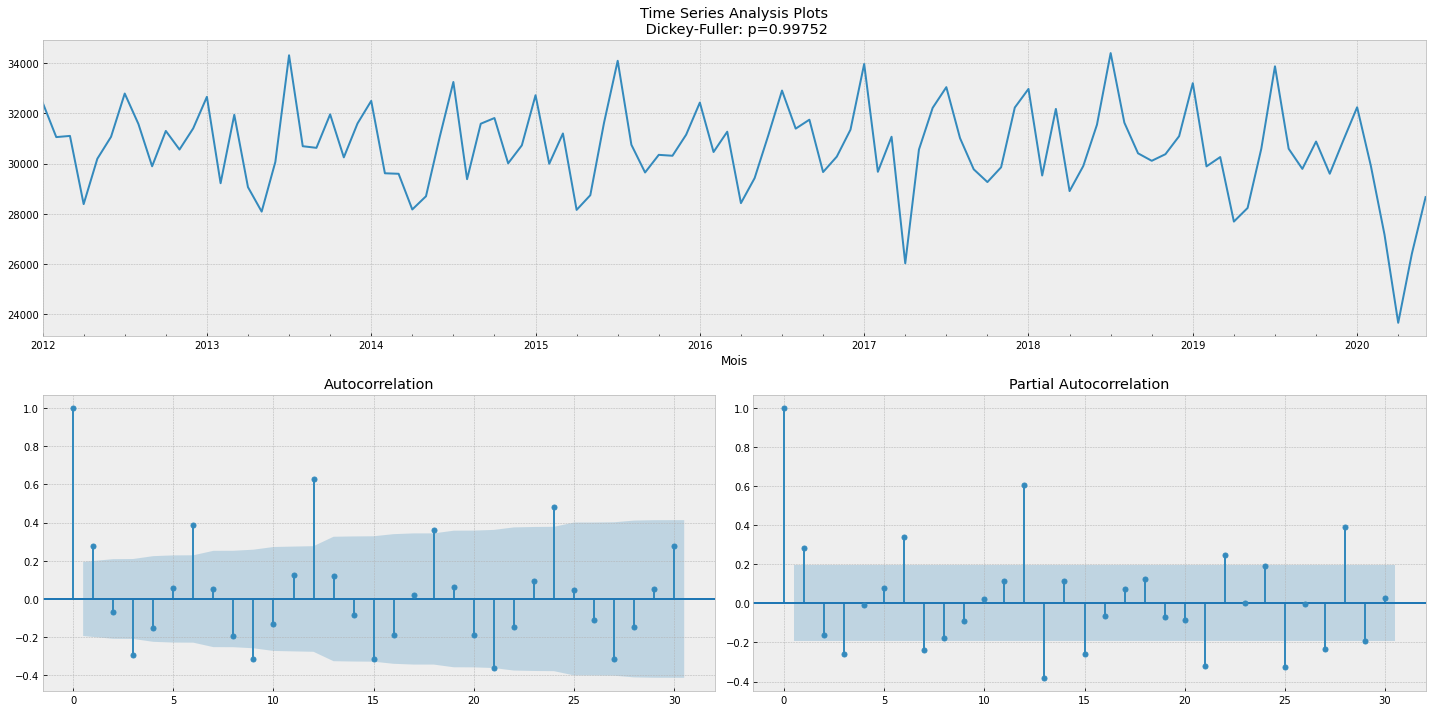

In [31]:
tsplot(y, lags=30)

On observe une différenciation égale à 12. On va donc faire une différenciation I - B avec B = 12.

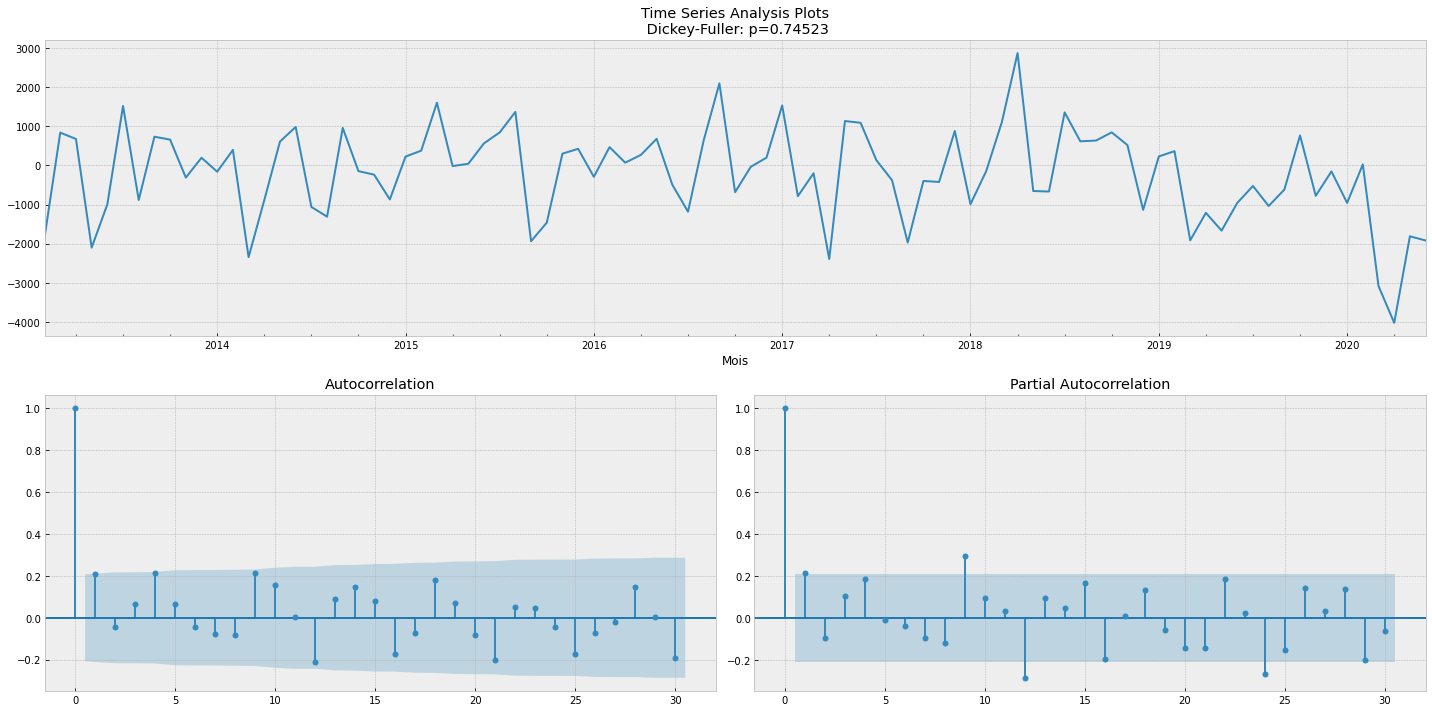

In [32]:
y2 = y - y.shift(12)
tsplot(y2[13:], lags=30)

Une fois la première différenciation réalisée, on remarque qu'aucun retard ne sort de la zone définie par notre autocorrélogramme. On va don pouvoir déterminer les paramètres p, q, d, P, Q et D de notre modèle SARIMA en sachant que s = 12.

On regarde si notre série temporelle est stationnaire ou non. Pour cela, on réalise un test de Dickey-Fuller avec les hypothèses suivantes :
- Hypothèse nulle (H0) : La consommation totale corrigée est issue d'une racine unitaire, elle est donc non stationnaire.
- Hypothèse alternative (H1) : La consommation totale corrigée n'est pas issue d'une racine unitaire, elle est donc stationnaire.

On obtient une p-value supérieur à p > 0.05 au test de Dickey-Fuller. On ne peut donc pas rejeter l'hypothèse nulle. La consommation totale corrigée est issue d'une racine unitaire et est non stationnaire. 

On détermine les meilleures paramètres de notre modèle SARIMA en utilisant une méthode de test automatisée se basant sur l'AIC et le BIC.

In [33]:
# On attribue des valeurs comprises entre 0 et 3 (exclus) pour p, q et d.
p = d = q = range(0, 3)

# On génère toutes les combinaisons possibles avec p, q et d
pdq = list(itertools.product(p, d, q))

# On fait la même chose pour trouver les paramètres P, Q et D
# On fixe la valeur de s à 12 car on la déterminait auparavant
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# On utilise la fonction de gridsearch
sarimax_gridsearch(y, pdq, pdqs)

,pdq,pdqs,bic,aic
113,"(0, 1, 1)","(0, 2, 1, 12)",1360.097607,1353.066191
114,"(0, 1, 1)","(0, 2, 2, 12)",1361.530472,1352.155250
140,"(0, 1, 2)","(0, 2, 1, 12)",1362.264404,1352.889183
569,"(2, 1, 0)","(0, 2, 1, 12)",1362.476116,1353.100894
122,"(0, 1, 1)","(1, 2, 1, 12)",1362.621066,1353.245844


Les paramètres les plus adaptés à notre modèle sont (0, 1, 1) et (0, 2, 1, 12). On va donc construire notre modèle sur ces paramètres et faire nos prédictions à partir de cela. 

##### b) Définition du modèle

In [34]:
model = SARIMAX(y, order=(0, 1 ,1), seasonal_order = (0,2,1, 12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:       Consommation totale corrigée   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 2, 1, 12)   Log Likelihood                -673.533
Date:                            Wed, 30 Dec 2020   AIC                           1353.066
Time:                                    15:43:48   BIC                           1360.098
Sample:                                01-01-2012   HQIC                          1355.879
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5033      0.076     -6.579      0.000      -0.653      -0.353
ma.S.L12      -0.9983      0.186   

##### c) Evaluation du modèle et prédiction

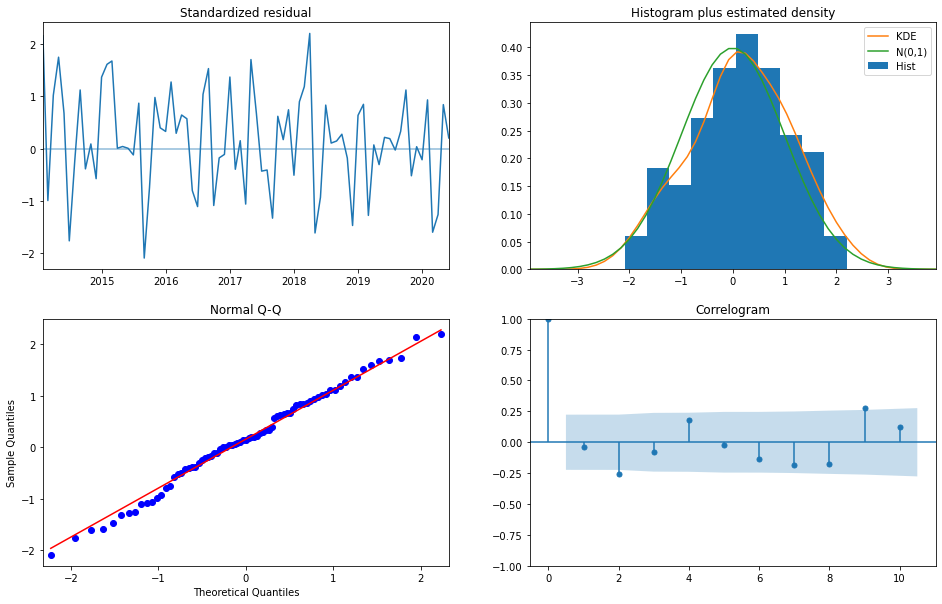

In [35]:
results.plot_diagnostics(figsize=(16,10));

In [36]:
st.shapiro(results.resid)

ShapiroResult(statistic=0.4395081400871277, pvalue=6.0174730177563405e-18)

La distribution de nos résidus semble suivre une loi normale. On vérifie cela avec un test de Shapiro-Wilk se basant sur les hypothèses suivantes : 
- H0 : Il est peu probable que la distribution de nos résidus suive une loi normale
- H1 : Il est probable que la distribution de nos résidus suive une loi normale

La p-value est inférieure à 0.05. On peut donc rejeter l'hypothèse H0 selon laquelle il est peu probable que la distribution de nos résidus suive un loi normale. 

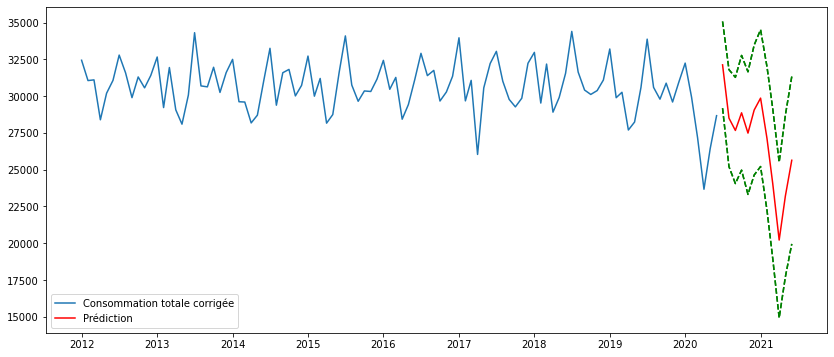

In [37]:
pred_model1 = results.get_forecast(12)
pred = pred_model1.predicted_mean
pred_l = pred_model1.conf_int(alpha=0.05)
pred_u = pred_model1.conf_int(alpha=0.05)

plt.figure(figsize=(14,6))
plt.plot(y, label='Consommation totale corrigée')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), pred, color='r', label='Prédiction')
plt.plot(pd.date_range(y.index[len(df)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(y.index[len(df)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.legend()
plt.show()

Une fois la prédiction réalisée sur les 12 prochains mois, on va tester notre modèle. Pour cela, on lui demande de faire une prédiction sur des données déjà connues (les 12 mois que l'on connait, c'est-à-dire juin 2019 à mai 2020).

In [38]:
y_true = y[-12:]
y = y.shift(-12).dropna()

In [39]:
model = SARIMAX(y, order=(0, 1 ,1), seasonal_order = (0,2,1, 12))
results2 = model.fit()

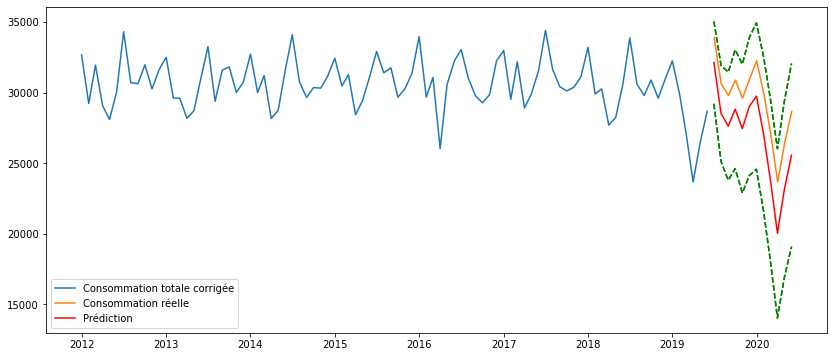

In [40]:
pred_model2 = results2.get_forecast(12)
pred2 = pred_model2.predicted_mean
pred_l2 = pred_model2.conf_int(alpha=0.05)
pred_u2 = pred_model2.conf_int(alpha=0.05)

plt.figure(figsize=(14,6))
plt.plot(y, label='Consommation totale corrigée')
plt.plot(y_true, label = 'Consommation réelle')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), pred2, color='r', label='Prédiction')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), pred_l2, color='g', linestyle='--')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), pred_u2, color='g', linestyle='--')
plt.legend()
plt.show()

On observe que notre prédiction est légèrement plus faible que la consommation réelle. La consommation réelle se situe entre notre prédiction et la borne supérieure de notre intervalle de confiance. Il a réussi à prendre en compte la baisse importante du début 2020 contrairement à la méthode de Holt-Winters qui n'est pas adapté lors de tendance non-stable.

Pour appuyer cette analyse de la performance, on calcule différents indices qui sont identiques à ceux de la méthode de Holt-Winters.

In [41]:
y_pred = pred2

In [42]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  2567.5964987067377
MSE =  6961541.085131184
RMSE =  2638.4732488943646
MAPE =  9.953844653797837


Les scores de la méthode SARIMA sont moins bons que ceux de la méthode de Holt-Winters. On obtient une marge d'erreur sur les valeurs propres de presque 10% (MAPE) contre 1.36% pour la méthode de Holt-Winters. Cependant, il ne faut pas oublier que notre série temporelle contient une tendance qui n'est plus stable à partir de 2020. La méthode de Holt-Winters aurait été plus performante si la tendance restait stable mais dans le cas contraire, la méthode SARIMA permet de mieux prédire les valeurs influencées par la non-stabilité de la tendance.